# **Multimodal neurons**

---

This is the structure in which we have organized our code:
```
├── data/                           	# -> Data folder
├── neuron_ids.txt                      # -> Neuron/channel ids for each "concept"
└── results/                            # -> Results of our experiments
```

## Environment configuration

In [44]:
# For running this project in a hosted runtime

# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# Project directory (change this to the Google Drive directory in which you have saved the project)
# %cd /content/drive/MyDrive/university/roes/multimodal neurons/

# Choose your path (for collaboration) - run in a hosted runtime
# curr_path = "/content/drive/MyDrive/university/roes/multimodal neurons/"

curr_path = "./" # run locally

# "PLAY" IN YOUR OWN COPY

In [45]:
# Environment configuration

# Dependencies and imports
# !pip install torch torchvision torchaudio ftfy regex tqdm deeplake
# !pip install git+https://github.com/openai/CLIP.git # CLIP
# !pip install torch-lucent
# !pip install git+https://github.com/microsoft/CLAP.git # CLAP
# !pip install laion-clap # or this implementation of CLAP

import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import random
import os
import torch.nn as nn
from tqdm import tqdm
import time
import re
import itertools
import warnings
from PIL import Image
from torchvision import transforms, datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import clip
from msclap import CLAP
import laion_clap

import deeplake

from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence
from lucent.modelzoo.util import get_model_layers
from lucent.misc.io import show
from lucent.optvis.param.color import to_valid_rgb

from transformers import AutoProcessor, AutoModel

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data
data_path = curr_path + "data/"

## CLIP model

In [46]:
# CLIP available models

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [47]:
# Load the CLIP model

model, preprocess = clip.load("RN50x4", device=device)
# model, preprocess = AutoModel.from_pretrained("facebook/metaclip-b32-400m"), AutoProcessor.from_pretrained("facebook/metaclip-b32-400m") # MetaCLIP

model.eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Zero-shot classification

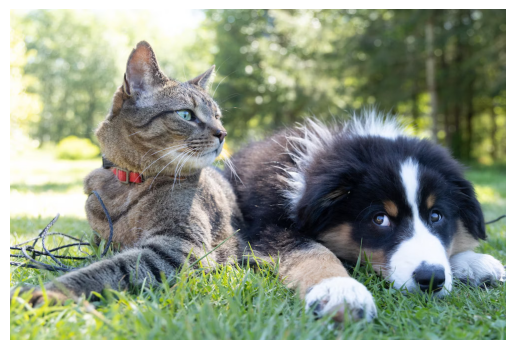

This is a dog: 0.0014295578002929688
This is a cat: 0.0018072128295898438
This is a dog and a cat: 0.99658203125


In [48]:
# Example usage (zero-shot classification)

# Show image
image = Image.open(data_path + "dog_cat.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess image
image = preprocess(Image.open(data_path + "dog_cat.jpg")).unsqueeze(0).to(device)

# Tokenize text
texts = ["This is a dog", "This is a cat", "This is a dog and a cat"]
text_tokens = clip.tokenize(texts).to(device)

# Calculate similarity
with torch.no_grad():
  image_features = model.encode_image(image)
  text_features = model.encode_text(text_tokens)

  logits_per_image, logits_per_text = model(image, text_tokens)
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for i, text in enumerate(texts):
    print(f"{text}: {probs[0][i]}")

## Feature visualization

In [49]:
# Vision side of the CLIP model

vision_side = model.visual
# vision_side = model.vision_model # MetaCLIP -> transformer architecture

In [50]:
# Vision side model layers

layers = get_model_layers(vision_side)
print(layers)

['conv1', 'bn1', 'relu1', 'conv2', 'bn2', 'relu2', 'conv3', 'bn3', 'relu3', 'avgpool', 'layer1', 'layer1_0', 'layer1_0_conv1', 'layer1_0_bn1', 'layer1_0_relu1', 'layer1_0_conv2', 'layer1_0_bn2', 'layer1_0_relu2', 'layer1_0_avgpool', 'layer1_0_conv3', 'layer1_0_bn3', 'layer1_0_relu3', 'layer1_0_downsample', 'layer1_0_downsample_-1', 'layer1_0_downsample_0', 'layer1_0_downsample_1', 'layer1_1', 'layer1_1_conv1', 'layer1_1_bn1', 'layer1_1_relu1', 'layer1_1_conv2', 'layer1_1_bn2', 'layer1_1_relu2', 'layer1_1_avgpool', 'layer1_1_conv3', 'layer1_1_bn3', 'layer1_1_relu3', 'layer1_2', 'layer1_2_conv1', 'layer1_2_bn1', 'layer1_2_relu1', 'layer1_2_conv2', 'layer1_2_bn2', 'layer1_2_relu2', 'layer1_2_avgpool', 'layer1_2_conv3', 'layer1_2_bn3', 'layer1_2_relu3', 'layer1_3', 'layer1_3_conv1', 'layer1_3_bn1', 'layer1_3_relu1', 'layer1_3_conv2', 'layer1_3_bn2', 'layer1_3_relu2', 'layer1_3_avgpool', 'layer1_3_conv3', 'layer1_3_bn3', 'layer1_3_relu3', 'layer2', 'layer2_0', 'layer2_0_conv1', 'layer2_0_bn

100%|███████████████████████████████████████████████████| 512/512 [00:23<00:00, 22.15it/s]



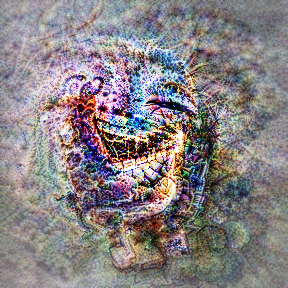

In [ ]:
# Define the layer and neuron/channel for feature visualization

# Note:
# * Channel optimization objective results in a repeating pattern
# * Neuron optimization objective shows spatial preferences

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))
# _ = render.render_vis(vision_side, "layer3_3_conv3:168", show_inline=True) # or this

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.61it/s]



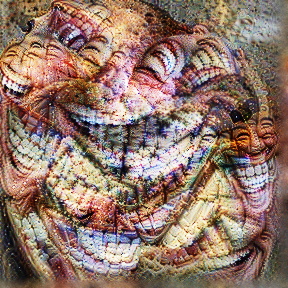

In [ ]:
# Here we try different tranformations (regularizers)

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_channel_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index)

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.79it/s]



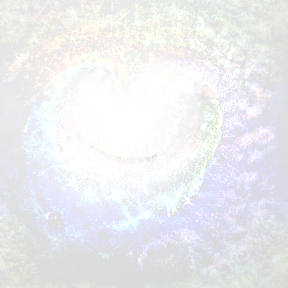

In [ ]:
# Define the layer and neuron/channel for feature visualization - let's try other objectives (blur alpha) -> interesting results

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_obj_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.neuron(layer_name, neuron_channel_index) - 1e2 * objectives.blur_alpha_each_step() # we experiment with this

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

In [ ]:
# Define the layer and neuron/channel for feature visualization - let's try other objectives (e.g. https://github.com/openai/CLIP-featurevis/blob/master/example_facets.py)

# I will write the code shortly...

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"
image_path = f"results/feature_vis_neuron_obj_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True, alpha=True)
obj = objectives.neuron(layer_name, neuron_channel_index) - 1e2 * objectives.blur_alpha_each_step()

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2),
        transform.collapse_alpha_random()
]

_ = render.render_vis(vision_side, obj, batch_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Deep dream

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.37it/s]



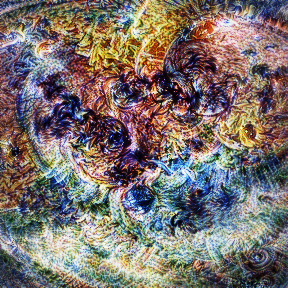

In [ ]:
# Define the layer and neuron/channel for feature visualization - deepdream

layer_name = "layer4_5_conv3"
image_path = f"results/feature_vis_deepdream_{layer_name}.png"

batch_param_f = lambda: param.image(288, batch=1, decorrelate=True)
obj = objectives.deepdream(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Diversity

100%|███████████████████████████████████████████████████| 512/512 [00:52<00:00,  9.67it/s]



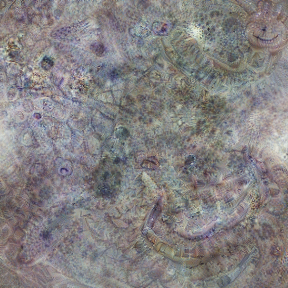

In [43]:
# Diversity -> this needs further investigation

layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy
image_path = f"results/feature_vis_diversity_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=4, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index) - 1e2 * objectives.diversity(layer_name)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path)

## Neural interactions

In [ ]:
# Neural interactions (combined neurons, etc.) -> very interesting, we will delve into this as soon as possible

# I will write the code shortly...

# * Negative visualizations
layer_name = "layer4_5_bn3"
neuron_channel_index = 1257 # 1739 is evil, 1512 is happy, 1257 is west africa
image_path = f"results/feature_vis_interactions_{layer_name}_{neuron_channel_index}.png"

batch_param_f = lambda: param.image(288, batch=2, decorrelate=True)
obj = objectives.channel(layer_name, neuron_channel_index, batch=1) - objectives.channel(layer_name, neuron_channel_index, batch=0)

_ = render.render_vis(vision_side, obj, batch_param_f, show_inline=True, save_image=True, image_name=image_path)

100%|███████████████████████████████████████████████████| 512/512 [00:29<00:00, 17.13it/s]


## Feature inversion - caricature

100%|███████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.58it/s]



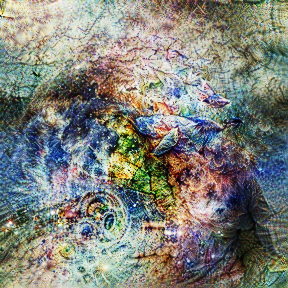

In [ ]:
# Caricature -> this needs caution for optimization instabilities, we must experiment more or implement another theoretical framework

layer_name = "layer4_5_conv3"

target_image = Image.open(data_path + "field.jpg")  # target image
transform_to_tensor = transforms.ToTensor()
target_image = transform_to_tensor(target_image).unsqueeze(0)
upsample = torch.nn.Upsample(size=(288, 288), mode='bilinear', align_corners=False)
target_image = upsample(target_image).squeeze(0).to(device)

image_path = f"results/feature_vis_caricature_{layer_name}_field.png"

obj = objectives.Objective.sum([
    1.0 * objectives.dot_compare(layer_name, cossim_pow=0.0)
  ])

params, image_f = param.image(288)
def stacked_param_f():
  return params, lambda: torch.stack([image_f()[0], target_image])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

# tforms = [
#         transform.pad(2, mode='constant', constant_value=.5),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.jitter(4),
#         transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
#         transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
#         transform.jitter(2)
# ]

# tforms = [
#     transform.pad(8, mode='constant', constant_value=.5),
#     transform.jitter(8),
#     transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
#     transform.random_rotate(list(range(-5, 5)) + [0]*5),
#     transform.jitter(2),
# ]

_ = render.render_vis(vision_side, obj, stacked_param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## Dataset samples

### **PACS dataset**

In [65]:
# Load the PACS dataset

pacs_ds = deeplake.load("hub://activeloop/pacs-train")

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



-

hub://activeloop/pacs-train loaded successfully.



In [66]:
# Dataloader

tform = transforms.Compose([ # transforms
    transforms.ToPILImage(),
    preprocess # CLIP preprocessing
])

batch_size = 4 # batch size

dataloader = pacs_ds.pytorch(batch_size=batch_size, num_workers=0, # dataloader
    transform = {'images': tform, 'labels': None}, shuffle=True)

### **ImageNet dataset**

In [27]:
# Load the ImageNet dataset

# Transformations
tform = transforms.Compose([
    # transforms.ToPILImage(),
    preprocess, # CLIP preprocessing
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# tform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

batch_size = 4 # batch size

imagenet_data_path = data_path + 'tiny-imagenet-200'
train_imagenet_dataset = datasets.ImageFolder(imagenet_data_path + '/train', transform=tform)
train_imagenet_loader = DataLoader(train_imagenet_dataset, batch_size=batch_size, shuffle=True) # dataloader
dataloader = train_imagenet_loader

In [51]:
# Top-k images/stimuli in the PACS/ImageNet dataset that most activate a given neuron (channel)

activations = []
def get_activation(name):
  def hook(model, input, output):
    activations.append(output.detach())
  return hook

# Define the layer and channel
layer_number = getattr(vision_side, 'layer4')
block = layer_number[5]
layer = getattr(block, 'bn3')
neuron_index = 1512 # 1512 (bn3) is "happy", 1739 (conv3) is "evil"

hook = layer.register_forward_hook(get_activation('layer_4_5_bn3')) # hook

# Process the images and record the activations
max_batches = 1000 # number of batches

batch_count = 0
saved_images = []
with torch.no_grad():
  for inputs in dataloader:
    if batch_count >= max_batches:
      break

    # images = inputs['images'] # PACS
    images = inputs[0] # ImageNet

    saved_images.extend(images.cpu().numpy())

    images = images.to(dtype=torch.float32, device=device)
    _ = vision_side(images)

    batch_count += 1

hook.remove()
activations = torch.cat(activations, dim=0)

# Top-k images in the dataset
k = 200
neuron_activations = activations[:, neuron_index].mean(dim=(1, 2))
top_image_indices = torch.argsort(neuron_activations, descending=True)[:k]
topk_images = [saved_images[i] for i in top_image_indices]
topk_activations = [activations[i, :].mean(dim=(1, 2)) for i in top_image_indices] # store the activations

# Show the top-k images
# fig, axes = plt.subplots(1, len(topk_images), figsize=(15, 5))
# if not isinstance(axes, (np.ndarray, list)):
#   axes = [axes]

# for i, image in enumerate(topk_images):
#   ax = axes[i]
#   ax.imshow(image.transpose(1, 2, 0))
#   # ax.imshow(image)
#   ax.set_title(f"Top-{i+1} image")
#   ax.axis('off')

# plt.savefig(f"results/dataset_samples_imagenet_happy.png") # save the fig

# plt.show()

## Multifaceted feature visualization

100%|███████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.46it/s]


100%|███████████████████████████████████████████████████| 512/512 [00:29<00:00, 17.32it/s]



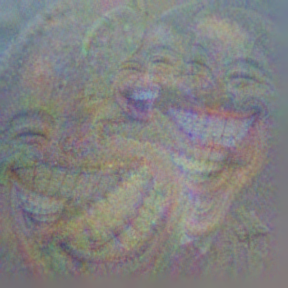

100%|███████████████████████████████████████████████████| 512/512 [00:31<00:00, 16.22it/s]



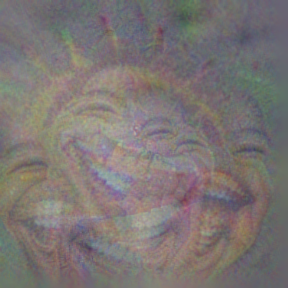

100%|███████████████████████████████████████████████████| 512/512 [00:28<00:00, 18.04it/s]



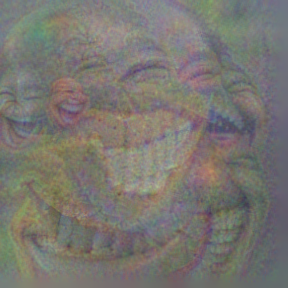

100%|███████████████████████████████████████████████████| 512/512 [00:30<00:00, 16.53it/s]



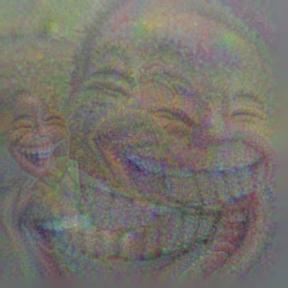

In [53]:
# Multifaceted feature visualization

# The set of images U are the training set images that maximally activate a neuron/channel (top-k images found earlier)
facets = 5 # number of facets

# Extract high-level features for each image
# We did it earlier (topk_activations)
# or FIXME: we can try something different
features = [activation.cpu().numpy() for activation in topk_activations]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(np.vstack(features))

# Run t-SNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_pca)

# Clustering
kmeans = KMeans(n_clusters=facets)
clusters = kmeans.fit_predict(features_tsne)

# Mean images
mean_images_initialization = []
for i in range(facets):
  cluster_indices = np.where(clusters == i)[0]
  cluster_images = [saved_images[i] for i in cluster_indices]
  mean_image = np.mean(cluster_images, axis=0)
  mean_images_initialization.append(mean_image)

# Feature visualization
layer_name = "layer4_5_bn3"
neuron_channel_index = 1512 # 1739 is evil, 1512 is happy, 89 is the "Donald Trump neuron"

# obj = objectives.channel(layer_name, neuron_channel_index) # objective, we can experiment more
# obj -= 1e-3 * objectives.L2()
# obj -= 0.25 * objectives.total_variation()
# obj -= 1.0 * objectives.blur_input_each_step()
obj = objectives.Objective.sum([
    objectives.channel(layer_name, neuron_channel_index),
    # -1e-3 * objectives.L2()
    -0.25 * objectives.total_variation(),
    # -1.0 * objectives.blur_input_each_step()
  ])

tforms = [ # we can experiment with these transformations
        transform.pad(2, mode='constant', constant_value=.5),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(4),
        transform.random_scale([0.995**n for n in range(-5, 80)] + [0.998**n for n in 2 * list(range(20, 40))]),
        transform.random_rotate(list(range(-20, 20))+list(range(-10, 10))+list(range(-5, 5)) + 5 * [0]),
        transform.jitter(2)
]

for i, initialization in enumerate(mean_images_initialization):
  image_path = f"results/multifaceted_feature_vis_imagenet_{layer_name}_{neuron_channel_index}_facet_{i+1}.png"
  transform_to_tensor = transforms.ToTensor()
  initialization = transform_to_tensor(initialization).unsqueeze(0).permute(0, 2, 3, 1).to(device).requires_grad_(True)
  def param_f(): # initialization
    return [initialization], to_valid_rgb(lambda: initialization, decorrelate=False)

  _ = render.render_vis(vision_side, obj, param_f, transforms=tforms, show_inline=True, save_image=True, image_name=image_path, thresholds=(512,))

## CLAP model

In [ ]:
# CLAP model

# MS CLAP
model, tokenizer, args = CLAP(version='2023', use_cuda=True).load_clap() # -> changed the config file to use the Cnn14 architecture

# LAION CLAP
# model = laion_clap.CLAP_Module(enable_fusion=False, device=device) # -> the audio side here is implemented with transformers
# model.load_ckpt()

model.to(device).eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
# Audio side of the CLAP model

# audio_side = model.model.audio_branch # LAION CLAP
audio_side = model.audio_encoder # MS CLAP

In [ ]:
# Audio side model layers

layers = get_model_layers(audio_side)
print(layers)

['base', 'base_spectrogram_extractor', 'base_spectrogram_extractor_stft', 'base_spectrogram_extractor_stft_conv_real', 'base_spectrogram_extractor_stft_conv_imag', 'base_logmel_extractor', 'base_bn0', 'base_conv_block1', 'base_conv_block1_conv1', 'base_conv_block1_conv2', 'base_conv_block1_bn1', 'base_conv_block1_bn2', 'base_conv_block2', 'base_conv_block2_conv1', 'base_conv_block2_conv2', 'base_conv_block2_bn1', 'base_conv_block2_bn2', 'base_conv_block3', 'base_conv_block3_conv1', 'base_conv_block3_conv2', 'base_conv_block3_bn1', 'base_conv_block3_bn2', 'base_conv_block4', 'base_conv_block4_conv1', 'base_conv_block4_conv2', 'base_conv_block4_bn1', 'base_conv_block4_bn2', 'base_conv_block5', 'base_conv_block5_conv1', 'base_conv_block5_conv2', 'base_conv_block5_bn1', 'base_conv_block5_bn2', 'base_conv_block6', 'base_conv_block6_conv1', 'base_conv_block6_conv2', 'base_conv_block6_bn1', 'base_conv_block6_bn2', 'base_fc1', 'base_fc_audioset', 'projection', 'projection_linear1', 'projection

In [ ]:
# Define the layer and neuron/channel for feature visualization -> this doesn't work, we will find a way to play with audio and specs

layer_name = "base_conv_block6_bn2"
neuron_channel_index = 6

batch_param_f = lambda: param.image(256, batch=1, decorrelate=True)
obj = objectives.neuron(layer_name, neuron_channel_index)

_ = render.render_vis(audio_side, obj, batch_param_f, show_inline=True)
# _ = render.render_vis(audio_side, "layer3_3_conv3:168", show_inline=True) # or this

  0%|                                                             | 0/512 [00:00<?, ?it/s]


AssertionError: There are no saved feature maps. Make sure to put the model in eval mode, like so: `model.to(device).eval()`. See README for example.